In [140]:
#multi-otsu thresholding for segmentation

import zarr
import dask.array as da
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from snakebids import generate_inputs
import seaborn as sns

In [194]:
bids_dir='/home/ROBARTS/alik/graham/cfmm-bids/Prado/LightsheetMicroscopy/bids_spimprep_20240215/'


inputs = generate_inputs(bids_dir=bids_dir,
                pybids_inputs=
                    {'spim':{
                        'filters':{
                            'suffix': 'spim',
                            'extension': 'ome.zarr.zip',
                            'staining': 'abeta',
                            'subject': 'mouse1',
                            'acquisition': '4x'}}})
                        
                        #'wildcards': [
                        #    'staining']}})


zarr_stain = inputs['spim'].path


In [195]:
#get lores image 
ds4_xy = da.from_zarr(zarr_stain,component='/4')
ds4_xy

dask.array<from-zarr, shape=(1616, 448, 378), dtype=>u2, chunksize=(1, 448, 378), chunktype=numpy.ndarray>

In [196]:
#this is only downsampled in xy, so can be pretty big still..

#one naive way to downsample is just take every N samples:
ds4_naive = ds4_xy[::4,:,:]
ds4_naive

dask.array<getitem, shape=(404, 448, 378), dtype=>u2, chunksize=(1, 448, 378), chunktype=numpy.ndarray>

In [197]:
#could alternatively average over chunks that are 4-thick in z
#  we achieve this by rechunking, then performing mean over axis-0 in each block
in_chunksize=(4,ds4_xy.shape[1],ds4_xy.shape[2])
out_chunksize=(1,ds4_xy.shape[1],ds4_xy.shape[2])

ds4_avg = ds4_xy.rechunk(in_chunksize).map_blocks(lambda x: np.mean(x,axis=0).reshape(1,x.shape[1],x.shape[2]),chunks=out_chunksize)
ds4_avg

dask.array<lambda, shape=(404, 448, 378), dtype=float64, chunksize=(1, 448, 378), chunktype=numpy.ndarray>

In [198]:
with ProgressBar():
    ds4_naive_arr =ds4_naive.compute()

[########################################] | 100% Completed | 11.03 s


In [199]:
with ProgressBar():
    ds4_avg_arr =ds4_avg.compute()

[########################################] | 100% Completed | 6.91 sms


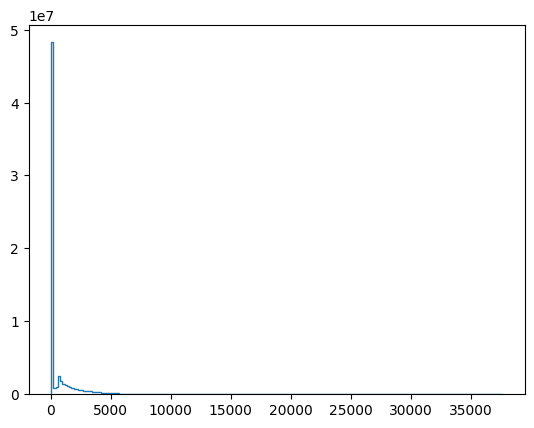

In [200]:
#plot histogram
(counts,bins)= np.histogram(ds4_avg_arr.flat,bins=200)
plt.stairs(counts,bins)

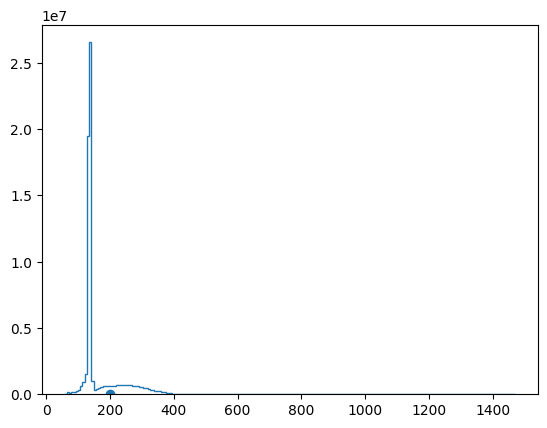

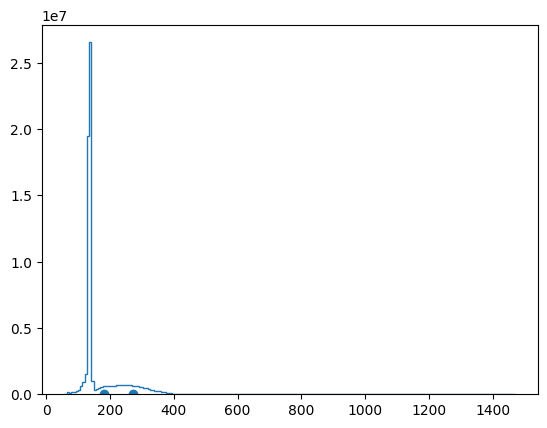

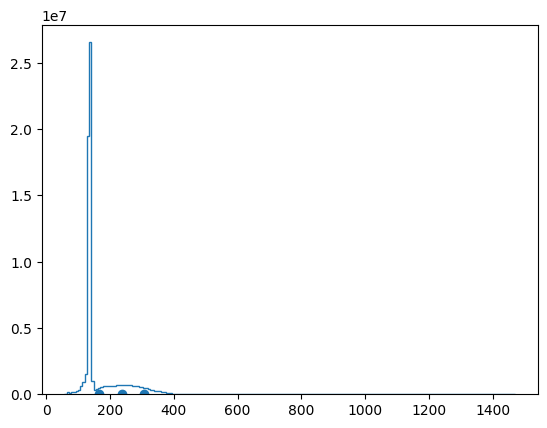

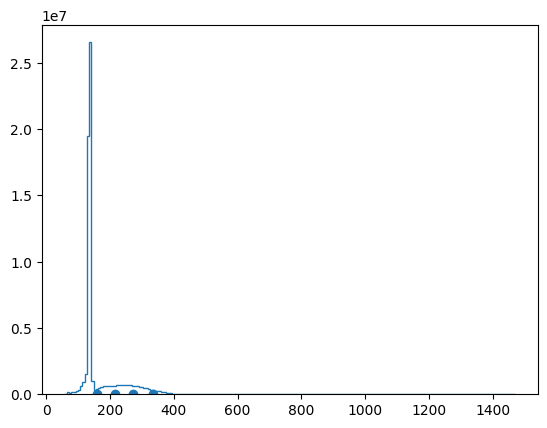

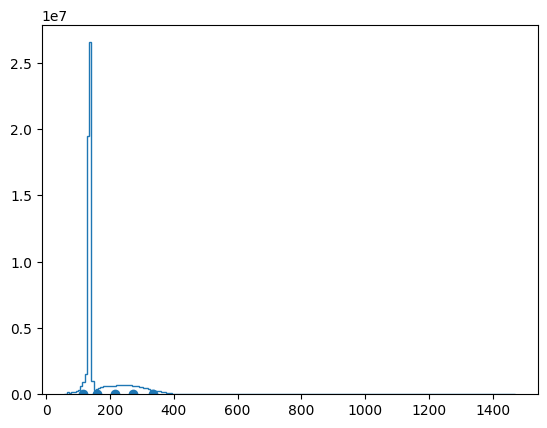

In [177]:
from skimage.filters import threshold_multiotsu

#look at various numbers of classes
for c in [2,3,4,5,6]:
    thresh =threshold_multiotsu(ds4_avg_arr,classes=c,nbins=200)
    plt.figure()
    plt.stairs(counts,bins)
    plt.scatter(thresh,np.zeros(thresh.shape))
    


In [201]:
from sklearn.mixture import GaussianMixture


(counts,bins)= np.histogram(ds4_avg_arr.flat,bins=200)

n_components=3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(ds4_avg_arr.reshape((ds4_avg_arr.size,1)))

GaussianMixture(n_components=3)

In [180]:
print(gmm.means_)
print(gmm.covariances_)
print(gmm.precisions_)
print(gmm.weights_)
print(gmm.sample)
#plt.stairs(counts,bins)
from scipy.stats import norm 


[[302.87075804]
 [134.56331508]
 [187.70424451]]
[[[2812.06687675]]

 [[   6.9647822 ]]

 [[4134.97954669]]]
[[[0.00035561]]

 [[0.14357951]]

 [[0.00024184]]]
[0.0905461  0.66526586 0.24418804]
<bound method BaseMixture.sample of GaussianMixture(n_components=3)>


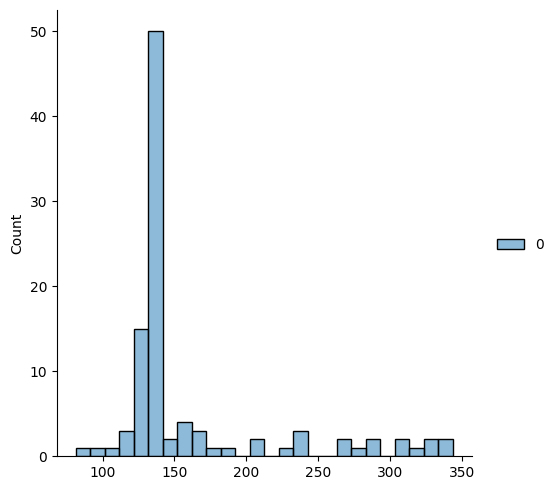

In [181]:

(X,y)=gmm.sample(100)
sns.displot(X,log_scale=[False,False])



In [160]:

gmm.predict(X)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1])

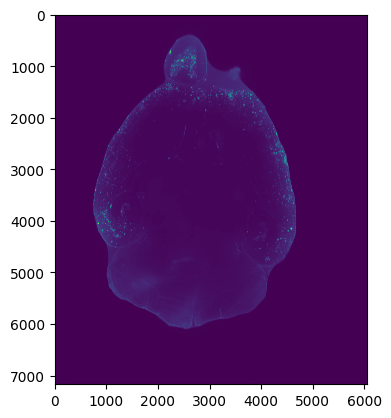

In [202]:
#try gmm segmentation


#try it out on a random fullres block
darr = da.from_zarr(zarr_stain,component='/0')
darr

img = darr.blocks[800,:,:].squeeze().compute()
plt.imshow(img)

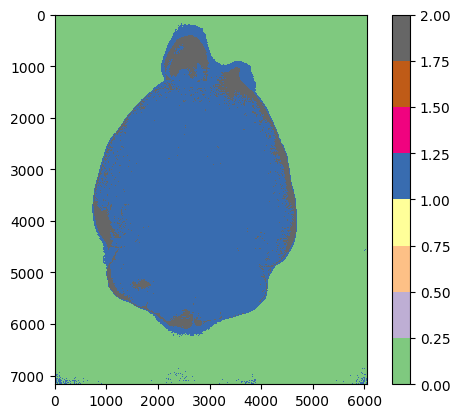

In [203]:
plt.imshow(gmm.predict(img.reshape((img.size,1))).reshape(img.shape).astype('uint8'),cmap='Accent',interpolation='nearest')
plt.colorbar()

In [187]:
predicted=gmm.predict(img.reshape((img.size,1)))
np.histogram(predicted)

(array([ 6011821,        0,        0,        0,        0, 24957577,
               0,        0,        0, 12395883]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))

In [190]:
print(predicted.size)

n0=np.sum(predicted==0)
n1=np.sum(predicted==1)
n2=np.sum(predicted==2)

print(n0+n1+n2)



43365281
43365281


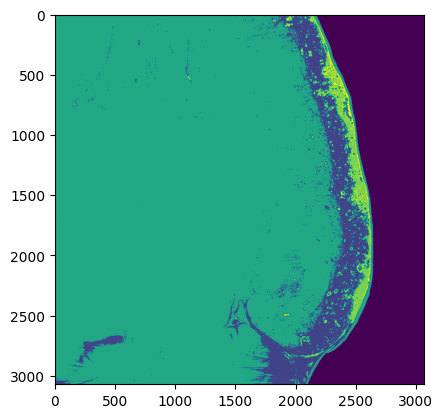

In [164]:
plt.imshow(gmm.predict(img.reshape((img.size,1))).reshape(img.shape))

In [115]:
#pick c=5
thresh =threshold_multiotsu(ds4_avg_arr,classes=c,nbins=200)

#try it out on a random fullres block
darr = da.from_zarr(zarr_stain,component='/0')
darr



dask.array<from-zarr, shape=(1616, 7169, 6049), dtype=>u2, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

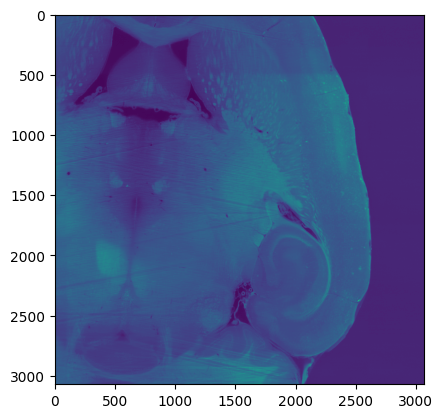

In [67]:
img = darr.blocks[800,2:5,2:5].squeeze().compute()
plt.imshow(img)

In [68]:
mask = img>thresh[0]


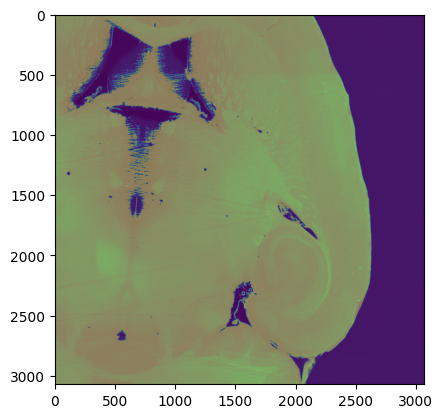

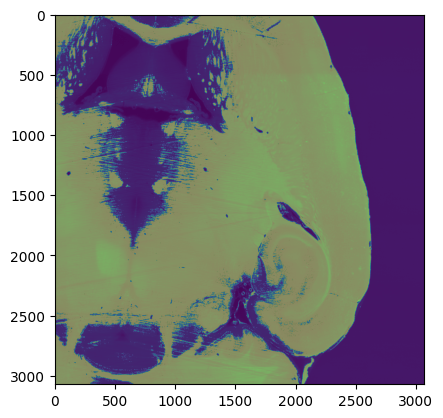

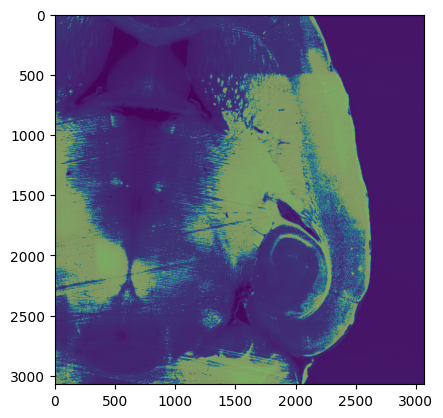

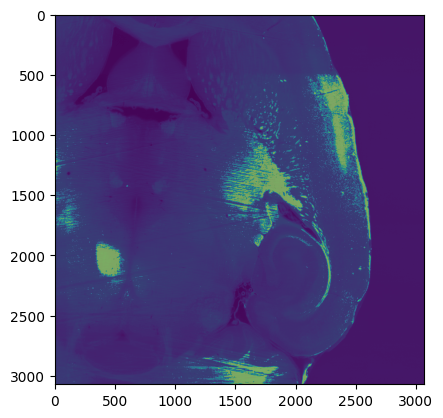

In [70]:

for level in range(len(thresh)):
    plt.figure()
    plt.imshow(img)
    plt.imshow(img>thresh[level],alpha=0.4)

In [ ]:
#now try it with abeta



In [76]:
#generate a full-res brain mask:

darr_mask = darr>thresh[0].astype('uint8')
darr_mask
with ProgressBar():
    darr_mask.to_zarr('mask.zarr',overwrite=True)

[                                        ] | 0% Completed | 5.78 s ms


KeyboardInterrupt: 